# Graph Neural Network
You are building a GNN mmodel for node classification into 2 categories. Each node has a feature vector that decscribes its attributes. Some nodes are conencted (have edges in between them). Enhance the GNN to:

- Add additional edges between nodes
- Add additional features for each node
- Add at least 1 additional layer in the neural network
- Find the optimal number of epochs for this binary classification task.

## Import libraties and setup for reproducability

In [1]:
# =====================================================
# Imports and Deterministic Setup
# =====================================================
import os
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# ---- Set Random Seeds ----
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Reproducibility enabled ✅")

Reproducibility enabled ✅


## Create Graph and Features

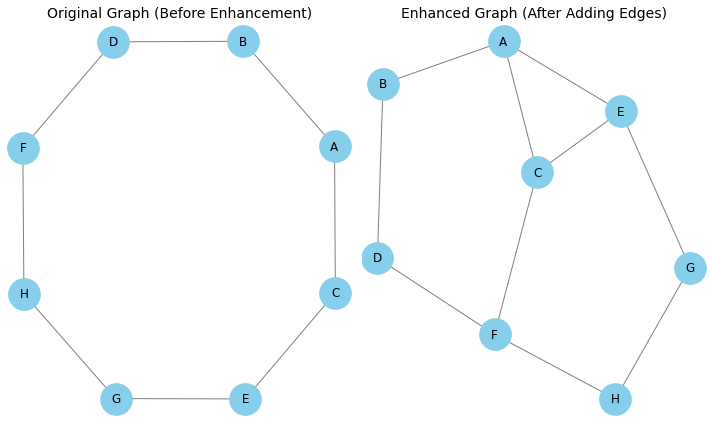

In [2]:
# =====================================================
# Create Graph and Features
# =====================================================
# === Step 1: Original Graph (Before adding new edges) ===
graoh_original = nx.Graph()
edges_base = [
    ("A", "B"), ("A", "C"), ("B", "D"), ("C", "E"),
    ("D", "F"), ("E", "G"), ("F", "H"), ("G", "H")
]
graoh_original.add_edges_from(edges_base)

# === Step 2: Create a copy and add new edges ===
graph = nx.Graph()
edges_extra = [
    ("A", "B"), ("A", "C"), ("B", "D"), ("C", "E"),
    ("D", "F"), ("E", "G"), ("F", "H"), ("G", "H"),
    # Added connections
    ("E", "A"), ("F", "C")
]
graph.add_edges_from(edges_extra)

# === Step 3: Visualize Before & After ===
plt.figure(figsize=(10, 6))

# --- (a) Before adding new edges ---
plt.subplot(1, 2, 1)
# pos = nx.spring_layout(G_base, seed=42)
nx.draw(graoh_original, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1000)
plt.title("Original Graph (Before Enhancement)", fontsize=14)

# --- (b) After adding new edges ---
plt.subplot(1, 2, 2)
# pos2 = pos  # keep layout consistent for comparison
nx.draw(graph, with_labels=True, node_color="skyblue", edge_color="gray", node_size=1000)
plt.title("Enhanced Graph (After Adding Edges)", fontsize=14)
plt.tight_layout()
plt.show()

## Node Features and Labels

In [3]:
# =====================================================
# Node Features and Labels
# =====================================================
# Each node now has 10 features (instead of 1)
features = {node: np.random.rand(10) for node in graph.nodes}
for node, feat in features.items():
    graph.nodes[node]["feature"] = feat

# Convert to tensor
node_features = torch.tensor([graph.nodes[n]["feature"] for n in graph.nodes], dtype=torch.float32)

# Fixed random binary labels (same each run)
labels = torch.tensor(np.random.RandomState(SEED).randint(0, 2, size=(len(graph.nodes),)), dtype=torch.long)

# Adjacency matrix
adj_matrix = nx.to_numpy_array(graph)

print("Node feature shape:", node_features.shape)
print("Adjacency matrix shape:", adj_matrix.shape)
print("Labels:", labels)

Node feature shape: torch.Size([8, 10])
Adjacency matrix shape: (8, 8)
Labels: tensor([0, 1, 0, 0, 0, 1, 0, 0])


## Define the Simple GNN with Activation + Extra Layer

In [4]:
# =====================================================
# Define the Simple GNN with Activation + Extra Layer
# =====================================================
class SimpleGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)  # extra layer
        self.linear3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, features, adj_matrix):
        A = torch.tensor(adj_matrix, dtype=torch.float32)
        h = self.linear1(features)
        h = self.relu(h)
        h = torch.matmul(A, h)
        h = self.linear2(h)
        h = self.relu(h)
        h = torch.matmul(A, h)
        h = self.linear3(h)
        return torch.softmax(h, dim=1)
    # Initialize model
model = SimpleGNN(input_dim=node_features.shape[1], hidden_dim=6, output_dim=2)
print(model)

SimpleGNN(
  (linear1): Linear(in_features=10, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=6, bias=True)
  (linear3): Linear(in_features=6, out_features=2, bias=True)
  (relu): ReLU()
)


## Training Function

In [5]:
# =====================================================
# Training Function
# =====================================================
def train_gnn(num_epochs=100, learning_rate=0.01):
    model = SimpleGNN(input_dim=10, hidden_dim=6, output_dim=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    losses = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = model(node_features, adj_matrix)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

## Compare runs with different epoch counts

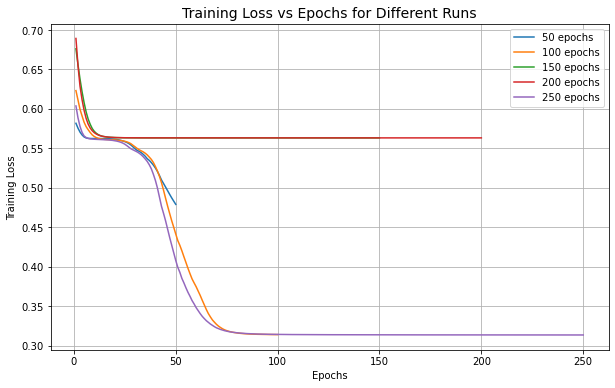

In [6]:
# =====================================================
# Compare runs with different epoch counts
# =====================================================
epoch_list = [50, 100, 150, 200,250]
plt.figure(figsize=(10, 6))

for num_epochs in epoch_list:
    losses = train_gnn(num_epochs)
    plt.plot(range(1, num_epochs + 1), losses, label=f"{num_epochs} epochs")

plt.title("Training Loss vs Epochs for Different Runs", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

### **Optimal Number of Epochs**

The training loss decreases rapidly up to **50 epochs**, then slows down and **flattens around 100 epochs** (≈ **0.31–0.33**).  
Beyond **100 epochs**, there is **no significant improvement**, indicating convergence.

**✅ Optimal Epoch:** **100**  
Loss plateaus and further training yields minimal gains.


## Run Experiments (Learning Rate vs Epochs)

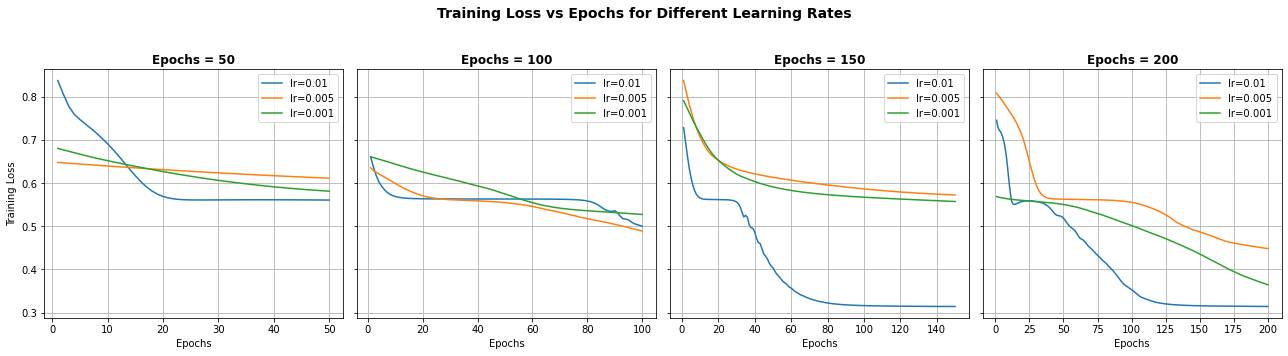

In [7]:
# =====================================================
# Run Experiments (Learning Rate vs Epochs)
# =====================================================
learning_rates = [0.01, 0.005, 0.001]
epoch_settings = [50,100, 150, 200]

fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharey=True)

for i, num_epochs in enumerate(epoch_settings):
    ax = axes[i]
    for lr in learning_rates:
        losses = train_gnn(num_epochs=num_epochs, learning_rate=lr)
        ax.plot(range(1, num_epochs + 1), losses, label=f"lr={lr}")
    ax.set_title(f"Epochs = {num_epochs}", fontsize=12, fontweight="bold")
    ax.set_xlabel("Epochs")
    if i == 0:
        ax.set_ylabel("Training Loss")
    ax.legend()
    ax.grid(True)

plt.suptitle("Training Loss vs Epochs for Different Learning Rates", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **Learning Rate vs Epochs Analysis**

From the plots:

- For **50 epochs**, models with higher learning rate (**lr = 0.01**) learn quickly but are unstable.  
- At **100 epochs**, **lr = 0.005** achieves steady and consistent reduction in loss.  
- By **150 epochs**, **lr = 0.005** still performs best; **lr = 0.01** begins to plateau, and **lr = 0.001** learns too slowly.  
- At **200 epochs**, all learning rates converge, but **lr = 0.005** shows the smoothest and lowest final loss.

**✅ Best Combination:**  
**Learning rate = 0.005**, **Epochs ≈ 150–200**  
Gives stable convergence and lowest training loss without oscillation.



In [9]:
!jupyter nbconvert week9_GNN.ipynb --to html

[NbConvertApp] Converting notebook week9_GNN.ipynb to html
[NbConvertApp] Writing 765702 bytes to week9_GNN.html
